### Cab-Driver Agent

#### Defining Time Matrix

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import pylab
import os

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Import the environment
from Env import CabDriver

# create an environment object 
env = CabDriver()

In [3]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

#### Tracking the state-action pairs for checking convergence


In [4]:
# Creating directories for saving the model and graph if the directories doesn't exist
directory_model = 'save_model'
if not os.path.exists(directory_model):
    os.makedirs(directory_model)

In [5]:
def Q_state(state):
    str_state = ""
    for s in state:
        if s < 10:
            str_state = str_state + "0" + str(s)
        else:
            str_state = str_state + str(s)
    return str_state

In [6]:
# Defining a function which will add new Q-values to the Q-dictionary. 
def add_to_dict(state, q_val, action, epi):
    state1 = Q_state(state)
    
    if action not in Q_dict[state1]:
        Q_dict[state1][action]= []    
    Q_dict[state1][action].append((epi, q_val))

In [7]:
# Function to save q-value for tracking states-action pair
def save_tracking_states():
    initialise_tracking_states()

    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action] += [q[1] for q in Q_dict[state][action]]

In [8]:
# Function to save q-value for tracking states-action pair
def initialise_tracking_states():
    sample_q_values = [('020405', (2, 4)), 
                       ('031006', (3, 5)), 
                       ('040502', (4, 3)), 
                       ('011402', (1, 3))]    #select any 4 Q-values
    for q_values in sample_q_values:
        state = q_values[0]
        action = q_values[1]
        States_track[state][action] = []    #this is an array which will have appended values of that state-action pair for every 2000th episode         

In [9]:
# Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [10]:
# Initialise Q_dictionary and States_tracked (for convergence)
Q_dict = collections.defaultdict(dict)
States_track = collections.defaultdict(dict)

initialise_tracking_states()

### Hyperparameters

In [11]:
#Defining parameters for the experiment

Episodes = 1000
AN_EPISOD_DAYS = 30                
LR = 0.001                   #learning rate
GAMMA = 0.91


threshold = 100            #every these many episodes, the 4 Q-values will be stored/appended (convergence graphs)
policy_threshold = 400    #every these many episodes,

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [12]:
class DQNAgent:
    
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = GAMMA
        self.learning_rate =  LR     
        self.epsilon = 1.0
        self.epsilon_decay = 0.999
        self.epsilon_min = 0.01
        self.batch_size = 32 
        self.train_start = 100
        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # create main model and target model
        self.model = self.build_model()
        self.target_model = self.build_model()

        # ++ if model weights are available load it from file 
        #self.load_model_weights = load_weights
        #if self.load_model_weights:
        #    self.model.load_weights("./cardriver_dqn.h5")
            
    def save_model_graph(self, suffix):
        # serialize model to JSON
        model_json = self.model.to_json()
        with open("./" + directory_model + "/cardriver_model_" + suffix + ".json", "w") as json_file:
            json_file.write(model_json)

    # approximate Q function using Neural Network
    def build_model(self):
        # Write your code here: Add layers to your neural nets       
        model = Sequential()

        # Input Layer: 5 locations + 24 hours + 7 days = 36
        # state [(1,0,0,0,0)(0 0 1 0 0 0  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0)(1 0 0 0 0 0 0)]
        
        # Hidden layers: 1, 2, 3, 4 
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))

        # Output Layer [Q(s,a1), Q(s,a2), ...... Q(s,ak)], k=21        
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        model.summary()
        return model

    
    def update_target_model(self):
        # update the target Q-value network to current Q-value network after training for a episode. 
        # this means that weights an biases of target Q-value network will become same as current Q-value network.
        self.target_model.set_weights(self.model.get_weights())
    
    
    def get_action(self, state, possible_actions):
        q_values = self.model.predict(state)
        if np.random.rand() <= self.epsilon:
            # explore: choose a random action from all possible actions
            # possible actions list would be given by environment
            choice = random.choice(possible_actions)
        else:
            # choose the action with the highest q(s, a)
            #q_values = self.model.predict(state)
            possible_action_q_values = [q_values[0][index] for index in possible_actions]
            max_q_value = np.max(possible_action_q_values)
            choice = list(q_values[0]).index(max_q_value)

        return choice, q_values[0][choice]

    
    def append_sample(self, state, action, reward, next_state, done):
        # Write your code here:
        # save sample <s,a,r,s'> to the replay memory
        # append the tuple (s, a, r, s', done) to memory (replay buffer) after every action
        self.memory.append((state, action, reward, next_state, done))
    
        # Decay in ε after we generate each sample from the environment
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay    
    
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        """
        Complete the 'train_model()' function with following logic:
        
        If the memory size is greater than mini-batch size, you randomly sample experiences 
        from memory as per the mini-batch size and do the following:
        
            1. Initialise your input and output batch for training the model
            2. Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
            3. Get Q(s', a) values from the last trained model
            4. Update the input batch as your encoded state and output batch as your Q-values
            5. Then fit your DQN model using the updated input and output batch.        
        """
        if len(self.memory) < self.train_start:
            return
        
        # Sample batch from the memory
        batch_size = min(self.batch_size, len(self.memory))
        mini_batch = random.sample(self.memory, self.batch_size)

        # 1. Initialise your input and output batch for training the model
        update_input = np.zeros((self.batch_size, self.state_size))
        update_target = np.zeros((self.batch_size, self.state_size)) 
        actions, rewards, terminal_states = [], [], []

        for i in range(self.batch_size):
            # Write your code from here

            update_input[i] = mini_batch[i][0]
            actions.append(mini_batch[i][1])
            rewards.append(mini_batch[i][2])
            update_target[i] = mini_batch[i][3]
            terminal_states.append(mini_batch[i][4])

        # 1. Predict the target from earlier model
        target = self.model.predict(update_input)

        # 2. Get the target for the Q-network
        target_qval = self.target_model.predict(update_target)  

        for i in range(self.batch_size):
            if terminal_states[i]:
                target[i][actions[i]] = rewards[i]
            else: # non-terminal state
                target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])

        # 4. Fit your model and track the loss values
        self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)

    
    def get_model_weights(self):
        return self.model.get_weights()
    
    
    def save(self, name):
        self.model.save_weights(name)

### DQN block

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                1184      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_5 (Dense)              (None, 21)                693       
Total params: 5,045
Trainable params: 5,045
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 

Episode: 79   score: 1763   memory length: 2000   epsilon: 0.009998671593271896
Episode: 80   score: 1605   memory length: 2000   epsilon: 0.009998671593271896
Episode: 81   score: 1476   memory length: 2000   epsilon: 0.009998671593271896
Episode: 82   score: 1532   memory length: 2000   epsilon: 0.009998671593271896
Episode: 83   score: 1673   memory length: 2000   epsilon: 0.009998671593271896
Episode: 84   score: 1479   memory length: 2000   epsilon: 0.009998671593271896
Episode: 85   score: 1443   memory length: 2000   epsilon: 0.009998671593271896
Episode: 86   score: 1384   memory length: 2000   epsilon: 0.009998671593271896
Episode: 87   score: 1358   memory length: 2000   epsilon: 0.009998671593271896
Episode: 88   score: 1195   memory length: 2000   epsilon: 0.009998671593271896
Episode: 89   score: 1725   memory length: 2000   epsilon: 0.009998671593271896
Episode: 90   score: 1364   memory length: 2000   epsilon: 0.009998671593271896
Episode: 91   score: 1305   memory lengt

Episode: 178   score: 1457   memory length: 2000   epsilon: 0.009998671593271896
Episode: 179   score: 1506   memory length: 2000   epsilon: 0.009998671593271896
Episode: 180   score: 1259   memory length: 2000   epsilon: 0.009998671593271896
Episode: 181   score: 1685   memory length: 2000   epsilon: 0.009998671593271896
Episode: 182   score: 1367   memory length: 2000   epsilon: 0.009998671593271896
Episode: 183   score: 1588   memory length: 2000   epsilon: 0.009998671593271896
Episode: 184   score: 1353   memory length: 2000   epsilon: 0.009998671593271896
Episode: 185   score: 1670   memory length: 2000   epsilon: 0.009998671593271896
Episode: 186   score: 1498   memory length: 2000   epsilon: 0.009998671593271896
Episode: 187   score: 1473   memory length: 2000   epsilon: 0.009998671593271896
Episode: 188   score: 1544   memory length: 2000   epsilon: 0.009998671593271896
Episode: 189   score: 1518   memory length: 2000   epsilon: 0.009998671593271896
Episode: 190   score: 1523  

Episode: 276   score: 1675   memory length: 2000   epsilon: 0.009998671593271896
Episode: 277   score: 1589   memory length: 2000   epsilon: 0.009998671593271896
Episode: 278   score: 1967   memory length: 2000   epsilon: 0.009998671593271896
Episode: 279   score: 1566   memory length: 2000   epsilon: 0.009998671593271896
Episode: 280   score: 1602   memory length: 2000   epsilon: 0.009998671593271896
Episode: 281   score: 1491   memory length: 2000   epsilon: 0.009998671593271896
Episode: 282   score: 1670   memory length: 2000   epsilon: 0.009998671593271896
Episode: 283   score: 1086   memory length: 2000   epsilon: 0.009998671593271896
Episode: 284   score: 1629   memory length: 2000   epsilon: 0.009998671593271896
Episode: 285   score: 1875   memory length: 2000   epsilon: 0.009998671593271896
Episode: 286   score: 1285   memory length: 2000   epsilon: 0.009998671593271896
Episode: 287   score: 1571   memory length: 2000   epsilon: 0.009998671593271896
Episode: 288   score: 1495  

Episode: 373   score: 1294   memory length: 2000   epsilon: 0.009998671593271896
Episode: 374   score: 1443   memory length: 2000   epsilon: 0.009998671593271896
Episode: 375   score: 1765   memory length: 2000   epsilon: 0.009998671593271896
Episode: 376   score: 1308   memory length: 2000   epsilon: 0.009998671593271896
Episode: 377   score: 1611   memory length: 2000   epsilon: 0.009998671593271896
Episode: 378   score: 1748   memory length: 2000   epsilon: 0.009998671593271896
Episode: 379   score: 1812   memory length: 2000   epsilon: 0.009998671593271896
Episode: 380   score: 1652   memory length: 2000   epsilon: 0.009998671593271896
Episode: 381   score: 1502   memory length: 2000   epsilon: 0.009998671593271896
Episode: 382   score: 1460   memory length: 2000   epsilon: 0.009998671593271896
Episode: 383   score: 1535   memory length: 2000   epsilon: 0.009998671593271896
Episode: 384   score: 1857   memory length: 2000   epsilon: 0.009998671593271896
Episode: 385   score: 1677  

Episode: 470   score: 1508   memory length: 2000   epsilon: 0.009998671593271896
Episode: 471   score: 1506   memory length: 2000   epsilon: 0.009998671593271896
Episode: 472   score: 1562   memory length: 2000   epsilon: 0.009998671593271896
Episode: 473   score: 1481   memory length: 2000   epsilon: 0.009998671593271896
Episode: 474   score: 1519   memory length: 2000   epsilon: 0.009998671593271896
Episode: 475   score: 1707   memory length: 2000   epsilon: 0.009998671593271896
Episode: 476   score: 1357   memory length: 2000   epsilon: 0.009998671593271896
Episode: 477   score: 1364   memory length: 2000   epsilon: 0.009998671593271896
Episode: 478   score: 1657   memory length: 2000   epsilon: 0.009998671593271896
Episode: 479   score: 1744   memory length: 2000   epsilon: 0.009998671593271896
Episode: 480   score: 1514   memory length: 2000   epsilon: 0.009998671593271896
Episode: 481   score: 1708   memory length: 2000   epsilon: 0.009998671593271896
Episode: 482   score: 1277  

Episode: 566   score: 1472   memory length: 2000   epsilon: 0.009998671593271896
Episode: 567   score: 1419   memory length: 2000   epsilon: 0.009998671593271896
Episode: 568   score: 1385   memory length: 2000   epsilon: 0.009998671593271896
Episode: 569   score: 1409   memory length: 2000   epsilon: 0.009998671593271896
Episode: 570   score: 1825   memory length: 2000   epsilon: 0.009998671593271896
Episode: 571   score: 1464   memory length: 2000   epsilon: 0.009998671593271896
Episode: 572   score: 1613   memory length: 2000   epsilon: 0.009998671593271896
Episode: 573   score: 1682   memory length: 2000   epsilon: 0.009998671593271896
Episode: 574   score: 1726   memory length: 2000   epsilon: 0.009998671593271896
Episode: 575   score: 1525   memory length: 2000   epsilon: 0.009998671593271896
Episode: 576   score: 1434   memory length: 2000   epsilon: 0.009998671593271896
Episode: 577   score: 1800   memory length: 2000   epsilon: 0.009998671593271896
Episode: 578   score: 1386  

Episode: 661   score: 1618   memory length: 2000   epsilon: 0.009998671593271896
Episode: 662   score: 1509   memory length: 2000   epsilon: 0.009998671593271896
Episode: 663   score: 1639   memory length: 2000   epsilon: 0.009998671593271896
Episode: 664   score: 1478   memory length: 2000   epsilon: 0.009998671593271896
Episode: 665   score: 1524   memory length: 2000   epsilon: 0.009998671593271896
Episode: 666   score: 1481   memory length: 2000   epsilon: 0.009998671593271896
Episode: 667   score: 1775   memory length: 2000   epsilon: 0.009998671593271896
Episode: 668   score: 1505   memory length: 2000   epsilon: 0.009998671593271896
Episode: 669   score: 1695   memory length: 2000   epsilon: 0.009998671593271896
Episode: 670   score: 1634   memory length: 2000   epsilon: 0.009998671593271896
Episode: 671   score: 1689   memory length: 2000   epsilon: 0.009998671593271896
Episode: 672   score: 1716   memory length: 2000   epsilon: 0.009998671593271896
Episode: 673   score: 1501  

Episode: 756   score: 1879   memory length: 2000   epsilon: 0.009998671593271896
Episode: 757   score: 1723   memory length: 2000   epsilon: 0.009998671593271896
Episode: 758   score: 1613   memory length: 2000   epsilon: 0.009998671593271896
Episode: 759   score: 1613   memory length: 2000   epsilon: 0.009998671593271896
Episode: 760   score: 1596   memory length: 2000   epsilon: 0.009998671593271896
Episode: 761   score: 1677   memory length: 2000   epsilon: 0.009998671593271896
Episode: 762   score: 1579   memory length: 2000   epsilon: 0.009998671593271896
Episode: 763   score: 1875   memory length: 2000   epsilon: 0.009998671593271896
Episode: 764   score: 1474   memory length: 2000   epsilon: 0.009998671593271896
Episode: 765   score: 1617   memory length: 2000   epsilon: 0.009998671593271896
Episode: 766   score: 1879   memory length: 2000   epsilon: 0.009998671593271896
Episode: 767   score: 1481   memory length: 2000   epsilon: 0.009998671593271896
Episode: 768   score: 1838  

Episode: 850   score: 1736   memory length: 2000   epsilon: 0.009998671593271896
Episode: 851   score: 1609   memory length: 2000   epsilon: 0.009998671593271896
Episode: 852   score: 1852   memory length: 2000   epsilon: 0.009998671593271896
Episode: 853   score: 1651   memory length: 2000   epsilon: 0.009998671593271896
Episode: 854   score: 1709   memory length: 2000   epsilon: 0.009998671593271896
Episode: 855   score: 1600   memory length: 2000   epsilon: 0.009998671593271896
Episode: 856   score: 1695   memory length: 2000   epsilon: 0.009998671593271896
Episode: 857   score: 1877   memory length: 2000   epsilon: 0.009998671593271896
Episode: 858   score: 1876   memory length: 2000   epsilon: 0.009998671593271896
Episode: 859   score: 1718   memory length: 2000   epsilon: 0.009998671593271896
Episode: 860   score: 1649   memory length: 2000   epsilon: 0.009998671593271896
Episode: 861   score: 1682   memory length: 2000   epsilon: 0.009998671593271896
Episode: 862   score: 1614  

Episode: 943   score: 1867   memory length: 2000   epsilon: 0.009998671593271896
Episode: 944   score: 1745   memory length: 2000   epsilon: 0.009998671593271896
Episode: 945   score: 1862   memory length: 2000   epsilon: 0.009998671593271896
Episode: 946   score: 1725   memory length: 2000   epsilon: 0.009998671593271896
Episode: 947   score: 1641   memory length: 2000   epsilon: 0.009998671593271896
Episode: 948   score: 1800   memory length: 2000   epsilon: 0.009998671593271896
Episode: 949   score: 1552   memory length: 2000   epsilon: 0.009998671593271896
Episode: 950   score: 1709   memory length: 2000   epsilon: 0.009998671593271896
Episode: 951   score: 1702   memory length: 2000   epsilon: 0.009998671593271896
Episode: 952   score: 1904   memory length: 2000   epsilon: 0.009998671593271896
Episode: 953   score: 1692   memory length: 2000   epsilon: 0.009998671593271896
Episode: 954   score: 1791   memory length: 2000   epsilon: 0.009998671593271896
Episode: 955   score: 1779  

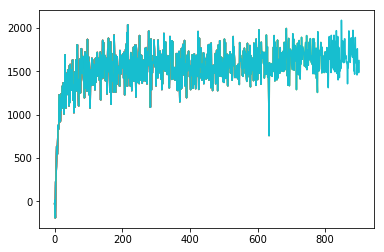

In [13]:
scores, episodes = [], []
state = env.state_init
state_encoded = env.state_encod_arch1(state)
state_size = len(state_encoded)
action_size = len(env.action_space)
agent = DQNAgent(state_size, action_size)

for episode in range(Episodes):

    # Write code here
    # Call the environment
    # Call all the initialised variables of the environment
    
    terminal_state = False
    score = 0
    reward = 0
    total_days = 1
    previous_day = 0
    current_day = 0
    env.reset()
    state = env.state_init
    
    #Call the DQN agent
                       
    while not terminal_state:
        
        # Write your code here
        # 1. Pick epsilon-greedy action from possible actions for the current state
        # 2. Evaluate your reward and next state
        # 3. Append the experience to the memory
        # 4. Train the model by calling function agent.train_model
        # 5. Keep a track of rewards, Q-values, loss
        
        state_encoded = env.state_encod_arch1(state)
        state_encoded = np.reshape(state_encoded, [1, state_size])
        
        # get possible list of actions from the environment
        possible_actions, action_list = env.requests(state)
        
        action, q_val = agent.get_action(state_encoded, possible_actions)
        
        reward = env.reward_func(state, env.action_space[action], Time_matrix)
        next_state = env.next_state_func(state, env.action_space[action], Time_matrix)
        next_state_encoded = env.state_encod_arch1(next_state)
        next_state_encoded = np.reshape(next_state_encoded, [1, state_size])
        
        agent.append_sample(state_encoded, action, reward, next_state_encoded, terminal_state)
        
        add_to_dict(state, q_val, env.action_space[action], episode)
        
        agent.train_model()
        
        score += reward
        previous_day = state[2]
        state = next_state
        current_day = state[2]
        if previous_day != current_day:
            total_days = total_days + 1
            
        if total_days > AN_EPISOD_DAYS:
            terminal_state = True
            
        if terminal_state == True:
            agent.update_target_model()
            scores.append(score)
            episodes.append(episode)  
    
    print("Episode:", episode, "  score:", score, "  memory length:", len(agent.memory), "  epsilon:", agent.epsilon)

    #TRACKING Q-VALUES
    if ((episode+1) % threshold) == 0:   #every threshold episode
        save_tracking_states()
        save_obj(States_track,'States_tracked')

    
    # plot episode versus score 
    if episode % threshold == 0: 
        pylab.plot(episodes, scores)
        pylab.savefig("./" + directory_model + "/cardriver_dqn_" + str(score) + ".png")    
    
    #save the model 
    if episode % policy_threshold == 0:         
        # Model binary h5 file
        agent.save("./" + directory_model + "/cardriver_dqn_" + str(score) + ".h5")
        
        # Model pickle file
        save_obj(agent.get_model_weights(), "./" + directory_model + "/cardriver_dqn_" + str(score))
    
    #SAVING POLICY
    if ((episode+1)% policy_threshold ) == 0:  #every policy_threshold episodes, the Q-dict will be saved
        save_obj(Q_dict,'Policy')  
        

### Tracking Convergence

In [14]:
Q_dict


defaultdict(dict,
            {'050702': {(5, 2): [(0, 0.01775775),
               (424, 337.82446),
               (463, 347.41748),
               (505, 332.7297),
               (574, 343.74902),
               (595, 334.07965),
               (742, 339.30038)],
              (4, 1): [(343, 309.5891)],
              (2, 1): [(451, 316.81955), (514, 315.3063)],
              (5, 4): [(488, 328.52454),
               (559, 318.34262),
               (620, 331.57257),
               (821, 321.55695)]},
             '021402': {(1, 3): [(0, 0.117597215)],
              (2, 4): [(3, 0.0)],
              (5, 4): [(3, 27.27835),
               (35, 233.40945),
               (46, 254.60852),
               (50, 266.1575),
               (88, 303.27),
               (96, 319.85223),
               (100, 322.9895),
               (103, 318.87787),
               (103, 333.23514),
               (105, 327.77078),
               (110, 319.40634),
               (112, 322.4434),
               (

In [15]:
# Q-Values for state-action pairs is obtained for diffrent episodes
#------------------------------------------------------------------
# Location C for 17:00 hours on TUESDAY
# result dictionary contains: 
# {(Action-Pair): [(Episode1, Q(s,a)), (Episode2, Q(s,a)),....]} 

Q_dict["031701"]

{(2, 5): [(5, 28.66984),
  (100, 273.6458),
  (105, 270.29684),
  (252, 298.00864),
  (329, 302.60535),
  (347, 292.75845),
  (377, 305.36444),
  (410, 295.69116),
  (483, 296.79843),
  (561, 297.82956)],
 (0, 0): [(9, 0.0),
  (637, 325.1934),
  (644, 320.79553),
  (647, 307.32764),
  (658, 311.56506),
  (658, 315.58197),
  (662, 309.01813),
  (670, 311.6342),
  (672, 314.86377),
  (676, 314.14615),
  (703, 311.80725),
  (714, 308.07178),
  (715, 306.32184),
  (718, 309.40707),
  (760, 314.43915),
  (767, 313.77844),
  (778, 316.01617),
  (779, 323.7242),
  (779, 320.43475),
  (781, 321.12756),
  (793, 313.5404),
  (826, 316.5811),
  (831, 314.82703),
  (835, 309.3151),
  (836, 316.7219),
  (843, 314.53214),
  (845, 314.31982),
  (849, 311.2652),
  (851, 316.0629),
  (871, 312.4697),
  (876, 309.91284),
  (879, 308.84552),
  (888, 318.8514),
  (892, 308.3769),
  (906, 308.1412),
  (910, 313.80722),
  (919, 321.82346),
  (925, 311.48254),
  (938, 312.5608),
  (967, 309.40802),
  (974, 3

In [16]:
# Q Value Tracking Location C for 17:00 hours on TUESDAY for action location C->D
# result dictionary contains: 
# [(Episode_ID: Q(s,a)), ...]} 

print("All actions taken from state 031701 : {}\n".format(Q_dict["031701"].keys()))

print("All Q-values for action (3, 4) :  (EpisodeID, Q-value)")
if (3, 4) in Q_dict["031701"]:
    print(Q_dict["031701"][(3, 4)])


All actions taken from state 031701 : dict_keys([(2, 5), (0, 0), (5, 2), (3, 5), (4, 5), (3, 4), (5, 4), (1, 2), (3, 1), (4, 3), (3, 2), (2, 3), (5, 1), (4, 2), (1, 3), (2, 1), (1, 4), (4, 1)])

All Q-values for action (3, 4) :  (EpisodeID, Q-value)
[(17, 162.76944), (31, 226.2609), (43, 248.26732), (56, 256.68787), (67, 281.3854), (94, 292.22375), (97, 296.38126), (106, 305.05157), (134, 323.30725), (150, 308.4555), (154, 305.794), (156, 309.06067), (168, 308.4286), (169, 305.81223), (176, 296.31866), (181, 306.9948), (198, 308.59482), (216, 307.02094), (225, 306.45636), (234, 304.6069), (276, 323.23044), (331, 323.79816), (379, 322.31482), (392, 317.57022), (405, 306.39282), (416, 317.357), (451, 323.40753), (474, 321.74423), (493, 319.4222), (507, 321.06512), (536, 321.8914), (547, 315.33987), (571, 324.90753), (581, 322.0387), (619, 329.93915), (656, 329.28494), (659, 323.2314), (676, 315.13678), (689, 324.61862), (711, 322.32602), (783, 337.11963), (812, 328.28552), (832, 334.0398

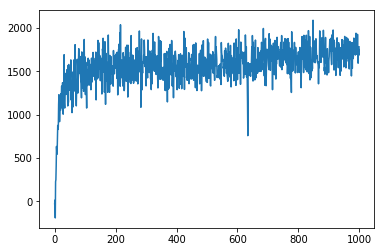

In [17]:
# Convergence graphs: Total Q-value per episode

pylab.plot(episodes, scores)

In [18]:
# TRACKING Q-VALUES FOR DEFINED STATE & ACTION
States_track

defaultdict(dict,
            {'020405': {(2, 4): []},
             '031006': {(3, 5): [320.22968,
               303.69214,
               321.80634,
               318.30942,
               319.492,
               317.92783,
               314.33783,
               327.68384,
               316.48062,
               322.24063,
               329.16098,
               328.96985,
               314.50983,
               323.4062,
               327.41342,
               324.21274,
               325.0258,
               328.76862,
               328.20056,
               322.16742,
               327.16895,
               333.0409,
               331.03323,
               332.50235,
               338.39847,
               336.2317,
               346.94037,
               338.92877,
               337.196,
               333.73044,
               334.15546,
               333.3837,
               337.47617,
               332.87268,
               338.6056,
               333.3358,
  

In [19]:
# Q value for state ["031006"] and action [(3, 5)]
Q_dict["031006"][(3, 5)]

[(112, 320.22968),
 (154, 303.69214),
 (180, 321.80634),
 (188, 318.30942),
 (188, 319.492),
 (191, 317.92783),
 (224, 314.33783),
 (258, 327.68384),
 (268, 316.48062),
 (322, 322.24063),
 (389, 329.16098),
 (391, 328.96985),
 (417, 314.50983),
 (431, 323.4062),
 (450, 327.41342),
 (490, 324.21274),
 (526, 325.0258),
 (540, 328.76862),
 (557, 328.20056),
 (577, 322.16742),
 (672, 327.16895),
 (695, 333.0409),
 (697, 331.03323),
 (734, 332.50235),
 (759, 338.39847),
 (779, 336.2317),
 (798, 346.94037),
 (810, 338.92877),
 (844, 337.196),
 (878, 333.73044),
 (901, 334.15546),
 (918, 333.3837),
 (929, 337.47617),
 (942, 332.87268),
 (953, 338.6056),
 (957, 333.3358),
 (971, 337.3445)]

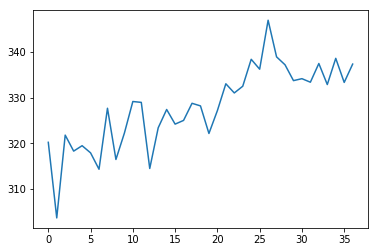

In [22]:
# Convergence of Q-Value for state 03-10-06 and action (3, 5)
pylab.plot(States_track['031006'][(3, 5)])

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [20]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))

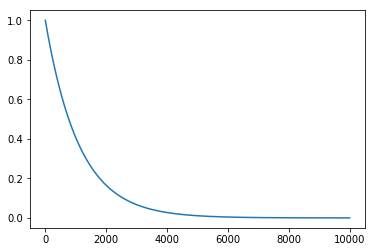

In [21]:
plt.plot(time, epsilon)
plt.show()